In [1]:
from catalogue import *

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

Using TensorFlow backend.


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

In [2]:
inputs, outputs, error, df_original = load_data()
print "Number of stars:", inputs.shape[0]
print "Shape of inputs, outputs, and error from loading data..."
print inputs.shape, outputs.shape, error.shape

/opt/conda/lib/python2.7/site-packages/pandas/core/frame.py:5085: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


Number of stars: 142750
Shape of inputs, outputs, and error from loading data...
(142750, 9) (142750, 3) (142750, 3)


In [3]:
inputs['u-g'] = inputs['u'].subtract(inputs['g'])
inputs['u-i'] = inputs['u'].subtract(inputs['i'])
inputs['g-r'] = inputs['g'].subtract(inputs['r'])
inputs['g-z'] = inputs['g'].subtract(inputs['z'])

m = 0.42 # u - g
b = 0.3 # g - r

# Apply a color cut to remove the contaminent stars (i.e. that are not giants or dwarfs)
colour_cut_a = (m*inputs['u-g'] - b > inputs['g-r'])
colour_cut_b = (m*inputs['u-g'] - b <= inputs['g-r'])


a_star=inputs[colour_cut_a]
outputs=outputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
error=error[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
inputs=inputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 

print "Number of stars after colour cut:", inputs.shape[0]

Number of stars after colour cut: 132141


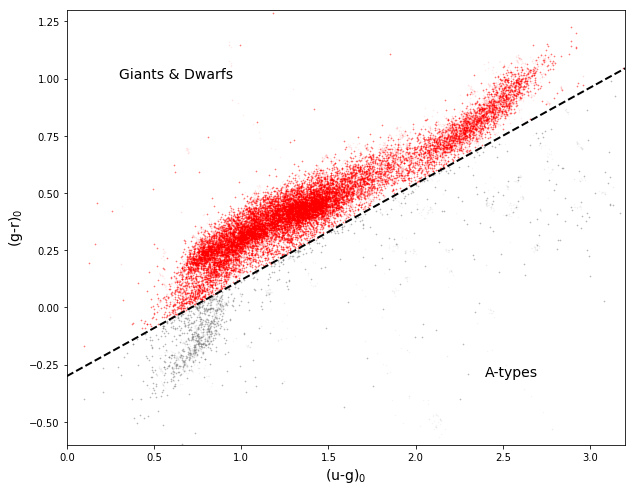

In [4]:
plt.figure(figsize=(10,8))
plt.scatter(inputs['u-g'], inputs['g-r'], s=0.5, c="red",alpha=0.05,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
plt.scatter(a_star['u-g'], a_star['g-r'], s=0.5, c='grey',alpha=0.05,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
line=np.arange(0.0,3.5,0.002)
plt.plot(line,0.42*line-0.3,"k--",lw=2)
plt.xlabel('(u-g)$_0$',fontsize=14)
plt.ylabel('(g-r)$_0$',fontsize=14)
plt.xlim(0.0,3.2)
plt.ylim(-0.6,1.3)
plt.ylabel('(g-r)$_0$')
plt.annotate(r"Giants & Dwarfs", xy=(0.3,1.0), xytext=(0.3, 1.0), color='black',size=14)
plt.annotate(r"A-types", xy=(2.4,-0.3), xytext=(2.4, -0.3), color='black',size=14)

plt.rcParams['pdf.fonttype']=42
plt.savefig("color_color_ML.pdf", format='pdf')
plt.show()

In [5]:
# Apply the color cuts for machine learning 
ui_thres = 1.3
gz_thres = 0.05

# Select only the lowest error in logg
logg_error_thres = 0.16

ml_cut =  (inputs['u-i'] >= ui_thres) & (inputs['u-i'] <= 2.6) & (inputs['g-z'] >= gz_thres)

input_forML2 = inputs[ml_cut]
output_forML2 = outputs[ml_cut]
error_forML2 = error[ml_cut]

logg_cut = (error_forML2['dlogg'] <= logg_error_thres)

input_finalML2 = input_forML2[logg_cut].reset_index(drop=True)
output_finalML2 = output_forML2[logg_cut].reset_index(drop=True)
error_finalML2 = error_forML2[logg_cut].reset_index(drop=True)

# For binary classification, we need to set the threshold for which
# logg we decide is a dwarf or a giant
output_finalML2['logg_binary'] = np.where(output_finalML2['logg'] > 3.5, 1, 0)

def classify_logg(val):
    if val >= 4.:
        return 2
    elif val < 4. and val > 3.:
        return 1
    else:
        return 0
    
output_finalML2['logg_trinary'] = output_finalML2.apply(lambda x: classify_logg(x['logg']), axis=1)

print "Number of stars after machine learning cuts in u-i, and g-z:", input_finalML2.shape[0]

Number of stars after machine learning cuts in u-i, and g-z: 76718


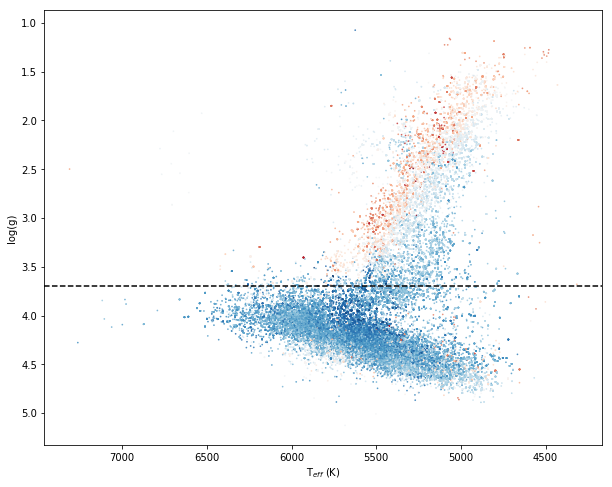

In [6]:
# Plot the position of the stars in a Teff-logg diagram
plt.figure(figsize=(10,8))
plt.scatter(output_finalML2['Teff'].values, output_finalML2['logg'].values, s=0.5,rasterized=True, c=output_finalML2['feh'],alpha=0.8,edgecolors=None, cmap=plt.cm.RdBu)
plt.axhline(y=3.7, color='k', linestyle='--')
plt.xlabel('T$_{eff}$ (K)')
plt.ylabel('log(g)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [7]:
###########
# Need to keep all these transformation => you should make the transformation subroutine
###########

colour_mean_logg = [input_finalML2[key].describe()['mean'] for key in input_finalML2]
colour_std_logg = [input_finalML2[key].describe()['std'] for key in input_finalML2]

mean_logg = output_finalML2['logg'].describe()['mean']
std_logg = output_finalML2['logg'].describe()['std']

error_logg_min=error_finalML2['dlogg'].describe()['min']
error_logg_max=error_finalML2['dlogg'].describe()['max']

stats_array = (input_finalML2, output_finalML2, error_finalML2)

# write final input and output dataframes to pickle file to load externally
with open('./stats_summary.pickle', 'r+') as f:
    pickle.dump(stats_array, f)

input_finalML2.sample(frac=1) # randomly shuffle order of pandas dataframe

# Normalize the data using custom normalize function
# default is using mean and stdev. Errors use min_max method
inputf = normalize(input_finalML2)
outputf = normalize(output_finalML2)
errorf = normalize(error_finalML2, 'min_max')

inputf_train = inputf.sample(frac=0.8, random_state=99)
inputf_test = inputf.loc[~inputf.index.isin(inputf_train.index), :]

outputf_train = outputf.sample(frac=0.8, random_state=99)
outputf_test = outputf.loc[~outputf.index.isin(outputf_train.index), :]

errorf_train = errorf.sample(frac=0.8, random_state=99)
errorf_test = outputf.loc[~errorf.index.isin(errorf_train.index), :]

train_frac = inputf_train.shape[0]/float(inputf.shape[0])
test_frac = inputf_test.shape[0]/float(inputf.shape[0])


print "Fraction of data for training:", train_frac
print "Fraction of data for testing:", test_frac
print "Check total is always 1.0:", train_frac+test_frac

Fraction of data for training: 0.7999947861
Fraction of data for testing: 0.2000052139
Check total is always 1.0: 1.0


In [8]:
x_train = inputf_train
y_train = outputf_train['logg_binary']

x_test = inputf_test
y_test = outputf_test['logg_binary']

x_error = errorf_test
y_error = errorf_train['dlogg']

In [9]:
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import accuracy_score

# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(x_train, y_train)
preds = gnb.predict(x_test)
# Evaluate accuracy
print "Accuracy", accuracy_score(y_test, preds)

Accuracy 0.77515641293


In [10]:
from keras.metrics import categorical_accuracy

seed = 7
np.random.seed(seed)

X = inputf.values.astype(float)
Y = outputf['logg_trinary'].values
print Y

[2 2 1 ..., 1 0 2]


In [11]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(outputf['logg_binary'])
encoded_Y = encoder.transform(outputf['logg_binary'])

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=13, kernel_initializer='normal', activation='relu')) #v input_dim=13,
    model.add(Dense(5096, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# evaluate model with standardized dataset
print "Baseline creation..."
estimator = KerasClassifier(build_fn=create_baseline, epochs=50, batch_size=1000, verbose=1)
kfold = StratifiedKFold(n_splits=3)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline creation...
Epoch 1/50
51145/51145 [==============================] - 5s 95us/step - loss: 0.4548 - acc: 0.7999
Epoch 2/50
51145/51145 [==============================] - 3s 59us/step - loss: 0.3392 - acc: 0.8664
Epoch 3/50
51145/51145 [==============================] - 3s 59us/step - loss: 0.3055 - acc: 0.8749
Epoch 4/50
51145/51145 [==============================] - 3s 55us/step - loss: 0.2851 - acc: 0.8770
Epoch 5/50
51145/51145 [==============================] - 3s 55us/step - loss: 0.2711 - acc: 0.8813
Epoch 6/50
51145/51145 [==============================] - 4s 78us/step - loss: 0.2611 - acc: 0.8849
Epoch 7/50
51145/51145 [==============================] - 3s 56us/step - loss: 0.2588 - acc: 0.8870
Epoch 8/50
51145/51145 [==============================] - 2s 43us/step - loss: 0.2525 - acc: 0.8895
Epoch 9/50
51145/51145 [==============================] - 2s 44us/step - loss: 0.2514 - acc: 0.8891
Epoch 10/50
51145/51145 [==============================] - 4s 71us/step - loss:

51145/51145 [==============================] - 4s 76us/step - loss: 0.1966 - acc: 0.9179
Epoch 31/50
51145/51145 [==============================] - 2s 42us/step - loss: 0.1980 - acc: 0.9160
Epoch 32/50
51145/51145 [==============================] - 3s 50us/step - loss: 0.1884 - acc: 0.9210
Epoch 33/50
51145/51145 [==============================] - 2s 43us/step - loss: 0.1895 - acc: 0.9197
Epoch 34/50
51145/51145 [==============================] - 3s 50us/step - loss: 0.1798 - acc: 0.9251
Epoch 35/50
51145/51145 [==============================] - 3s 50us/step - loss: 0.1853 - acc: 0.9212
Epoch 36/50
51145/51145 [==============================] - 3s 54us/step - loss: 0.1762 - acc: 0.9261
Epoch 37/50
51145/51145 [==============================] - 3s 59us/step - loss: 0.1742 - acc: 0.9279
Epoch 38/50
51145/51145 [==============================] - 3s 53us/step - loss: 0.1648 - acc: 0.9310
Epoch 39/50
51145/51145 [==============================] - 3s 58us/step - loss: 0.1643 - acc: 0.9301
Ep

In [ ]:
y_pred = cross_val_predict(clf,x,y,cv=10)
conf_mat = confusion_matrix(y,y_pred)

Train on 51401 samples, validate on 25317 samples
Epoch 1/100
51401/51401 [==============================] - 5s 89us/step - loss: -6.1416 - acc: 0.2033 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 2/100
51401/51401 [==============================] - 3s 58us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 3/100
51401/51401 [==============================] - 3s 51us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 4/100
51401/51401 [==============================] - 3s 55us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 5/100
51401/51401 [==============================] - 3s 59us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 6/100
51401/51401 [==============================] - 3s 65us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 7/100
51401/51401 [==============================] - 4s 76us/step - loss: -8.3628 - acc: 0.2051 - val_lo

/opt/conda/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121296). Check your callbacks.
  % delta_t_median)


51401/51401 [==============================] - 3s 58us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 47/100
51401/51401 [==============================] - 4s 70us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 48/100
51401/51401 [==============================] - 4s 71us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 49/100
51401/51401 [==============================] - 4s 68us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 50/100
51401/51401 [==============================] - 3s 54us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 51/100
51401/51401 [==============================] - 3s 65us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 52/100
51401/51401 [==============================] - 5s 90us/step - loss: -8.3628 - acc: 0.2051 - val_loss: -8.3833 - val_acc: 0.2054
Epoch 53/100
51401/51401 [

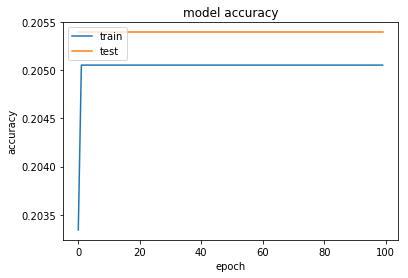

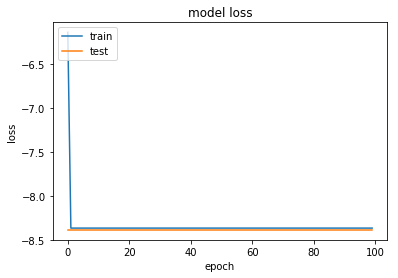

In [12]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
'''cvscores = []
for train, test in kfold.split(X, Y):
    # create model
    model = Sequential()

    model.add(Dense(32, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5096, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    history = model.fit(X[train], Y[train], validation_split=0.33, epochs=1000, batch_size=1000, verbose=1)
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100)
    cvscores.append(scores[1] * 100)
    print "%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))
'''
model = Sequential()

model.add(Dense(32, input_dim=13, kernel_initializer='normal', activation='relu'))
model.add(Dense(5096, kernel_initializer='normal', activation='relu'))
#model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=100, batch_size=1000, verbose=1)          
print history.history.keys() 
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

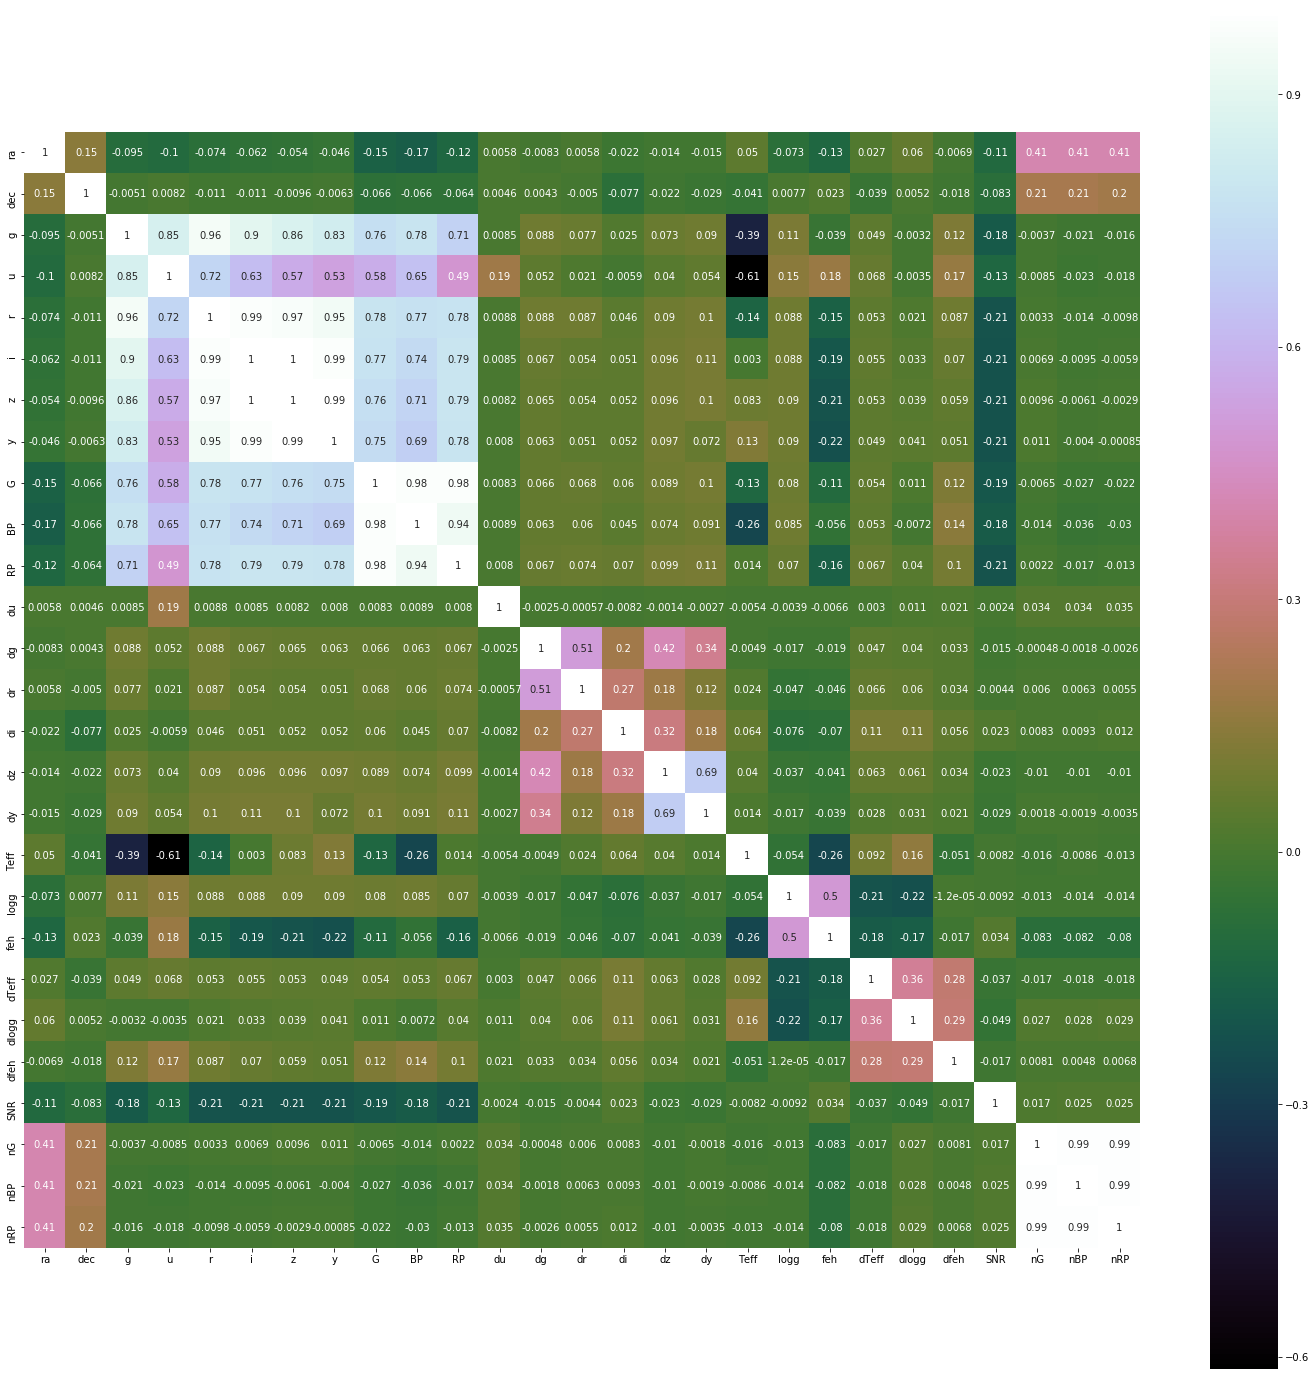

In [13]:
import seaborn as sns  

correlation = df_original.corr()  
plt.figure(figsize=(25, 25))  
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.savefig('correlation.pdf')

['acc', 'loss', 'val_acc', 'val_loss']


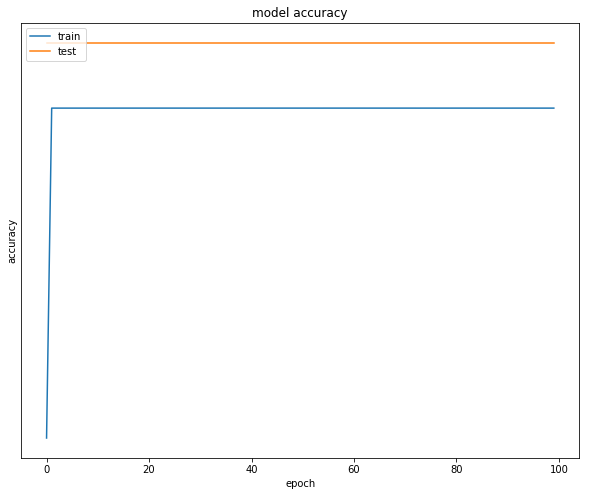

/opt/conda/lib/python2.7/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/opt/conda/lib/python2.7/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/opt/conda/lib/python2.7/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


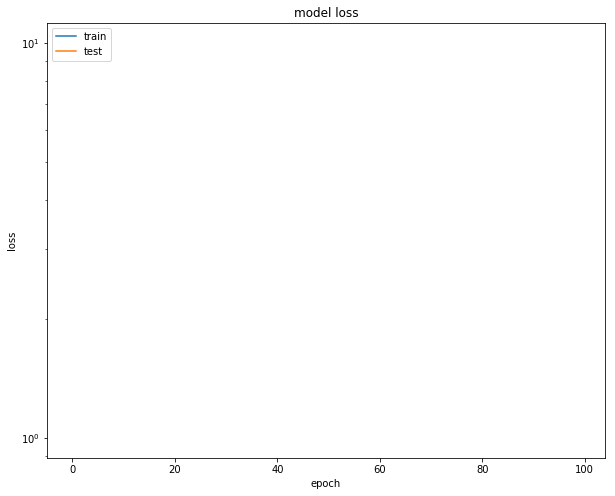

In [14]:
#history = model.fit(X, Y, validation_split=0.33, epochs=500, batch_size=1000, verbose=1)          
print history.history.keys() 
plt.figure(figsize=(10, 8))
# summarize history for accuracy
plt.semilogy(history.history['acc'])
plt.semilogy(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(10, 8))

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
 
# loading the iris dataset
print X.shape, Y.shape
 
# X -> features, y -> label
y = Y
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
 
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11).fit(X_train, y_train)
 
# accuracy on X_test
accuracy = knn.score(X_test, y_test)
print accuracy

print np.sqrt(len(Y))
 
# creating a confusion matrix
knn_predictions = knn.predict(X_test) 
cm = confusion_matrix(y_test, knn_predictions)

y_true = pd.Series(y_test)
y_pred = pd.Series(knn_predictions)

display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

#2*TP /(2*TP + FP + FN)
print "F1, 0", 2.*cm[0,0]/(np.sum(cm[0,:])+np.sum(cm[:,0]))
print "F1, 1", 2.*cm[1,1]/(np.sum(cm[1,:])+np.sum(cm[:,1]))
print "F1, 2", 2.*cm[2,2]/(np.sum(cm[2,:])+np.sum(cm[:,2]))

### Make colour colour plots to find out what the overfitting looks like at low k values
### TNSE


(76718, 13) (76718,)
0.929144942649
276.980143693


Predicted,0,1,2,All
True,,,,
0,2380,88,137,2605
1,81,3309,523,3913
2,117,413,12132,12662
All,2578,3810,12792,19180


F1, 0 0.918387034536
F1, 1 0.856920885666
F1, 2 0.953248998193


# 